TODO:
1. Найти распределение вероятностей для каждого состояния
2. Построить график количества людей в системе от времени
3. Построить график среднего времени нахождения клиента в системе от времени

In [43]:
import threading
import random
import time
from tqdm import tqdm

In [44]:
N_CLIENTS = 500

LAMBDA = 0.5
MU1 = 0.9
MU2 = 0.2

LOGGING = False

clients_list = []

event = threading.Event()
event.set()

In [45]:

timings = []

def get_state(chair1, chair2) -> str:
    if (not chair1.is_busy and not chair2.is_busy):
        return '00'
    if (not chair1.is_busy and chair2.is_busy):
        return '01'
    if (chair1.is_busy and not chair2.is_busy):
        return '10'
    if(chair1.is_blocked and chair2.is_busy):
        return 'b1'
    if (chair1.is_busy and chair2.is_busy):
        return '11'

In [46]:
class Client:
    def __init__(self, id):
        self.id = id
        self.start_time = None
        self.finish_time = None


In [47]:
class Chair1:
    def __init__(self):
        self.is_busy = False
        self.is_blocked = False
    
    def serving(self, client: Client):
        random.seed()
        ksi = random.expovariate(MU1)
        self.is_busy = True
        if LOGGING:
            print(f'client {client.id} is starting serving on the 1 chair')
        time.sleep(ksi)
        if LOGGING:
            print(f'client {client.id} finished serving on the 1 chair')
        return ksi
    

In [48]:
class Chair2:
    def __init__(self):
        self.is_busy = False
    
    def serving(self, client: Client):
        random.seed()
        ksi = random.expovariate(MU2)
        self.is_busy = True
        if LOGGING:
            print(f'client {client.id} is starting serving on the 2 chair')
        time.sleep(ksi)
        if LOGGING:
            print(f'client {client.id} finished serving on the 2 chair')
        return ksi

In [49]:
def append_timing(timings: list, state: str, time):
    if len(timings) != 0 and timings[-1][0] == state:
        timings.pop()
    timings.append((state, time))

In [50]:
def serving(client: Client, chair1: Chair1, chair2: Chair2, start_time):
    # if LOGGING:
    #     print(f'CLIENT {client.id} STARTED SERVING')
    client.start_time = start_time

    t = time.time() - start_time
    append_timing(timings, get_state(chair1, chair2), t)
    t_1 = t+chair1.serving(client)
    append_timing(timings, get_state(chair1, chair2), t_1)

    if not event.is_set():
        chair1.is_blocked = True
        # if LOGGING:
        #     print(f'client {client.id} is waiting for chair 2')

    t = time.time() - start_time
    event.wait()
    event.clear()
    t_w = time.time() - t

    t = time.time() - start_time
    append_timing(timings, get_state(chair1, chair2), t)
    chair1.is_busy = False
    chair1.is_blocked = False
    t_2 = t+chair2.serving(client)
    append_timing(timings, get_state(chair1, chair2), t_2)
    
    chair2.is_busy = False
    
    event.set()
    client.finish_time = t_2
    clients_list.append(client)


In [51]:
chair1 = Chair1()
chair2 = Chair2()

serving_start = time.time()

start_time = time.time()

for i in tqdm(range(N_CLIENTS)):
    random.seed()
    ksi = random.expovariate(LAMBDA)
    time.sleep(ksi)
    if not chair1.is_busy:
        x = threading.Thread(target=serving, args=(Client(i + 1), chair1, chair2, start_time))
        x.start()   
    # else:
    #     if LOGGING:
    #         print(f'CLIENT {i + 1} WAS REJECTED')
    
x.join()
# serving_end = time.time()


total_time = clients_list[-1].finish_time

# if LOGGING:
#     print(f'Serving finished, total time: {total_time}')
#     for client in clients_list: 
#         print(f'id: {client.id}, time in system: {client.finish_time - client.start_time}')

 30%|██▉       | 149/500 [04:50<11:59,  2.05s/it]

In [ ]:
probs = {'00': .0,
         '10': .0,
         '01': .0,
         '11': .0,
         'b1': .0}

prev_time = 0
for item in timings:
    state = item[0]
    time = item[1]
    probs[state] += (time - prev_time) / total_time
    prev_time = time  
    
for k,v in probs.items():
    print(f'pi_{k} ~ {v:.3f}')    

pi_00 ~ 0.049
pi_10 ~ 0.030
pi_01 ~ 0.229
pi_11 ~ 0.188
pi_b1 ~ 0.504


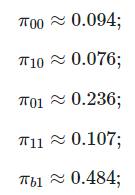